# Polynômes de chaos : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment obtenir les indices de Sobol' à partir d'un chaos polynomial.

# Problem statement

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\}$
* $E$ : Young modulus (Pa)
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4),
* $F$ : Loading (N)

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250.0, max= 260.0)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

## Un guide pour le chaos polynomial creux dans OpenTURNS

Voici les étapes principales et les objets pour créer un polynôme de chaos creux.
* Créer un plan d'expériences (de type `Sample`) et évaluer les sorties de la fonction $g$
* Créer la base polynomiale multivariée avec la classe `OrthogonalProductPolynomialFactory`. 
  * La règle par défaut `StandardDistributionPolynomialFactory` sélectionne automatiquement la famille de polynômes en fonction de la distribution ou bien l'orthogonalise si elle n'existe pas. Si nécessaire, personnaliser la famille polynomiale univariée pour chaque marginale (par exemple, pour la variable log-normale). 
  * Si nécessaire, personnaliser la règle d'énumération avec `HyperbolicAnisotropicEnumerateFunction`.
* Choisir une méthode de sélection de modèle avec `LeastSquaresMetaModelSelectionFactory`. 
  * Par défaut, l'algorithme de sélection de modèle permettant de créer la hiérarchie de modèles du plus creux au moins creux est la méthode Least angle regression (LARS). 
  * Par défaut, l'algorithme de choix du meilleur modèle dans la hiérarchie de modèles est la méthode `CorrectedLeaveOneOut`. Si nécessaire, choisir `KFold`. 
* Choisir une règle de calcul des coefficients du polynôme du chaos avec la classe `LeastSquaresStrategy`. Une alternative serait de calculer les coefficients par intégration avec `IntegrationStrategy`.
* Choisir une méthode de troncature pour déterminer combien de coefficients seront retenus dans l'exploration des modèles. La méthode de base est d'utiliser un nombre fixe avec `FixedStrategy`. L'alternative est la classe `SequentialStrategy` dont l'objectif est de conserver au plus un nombre donné de coefficients. 
* Mélangez les ingrédients; votre `FunctionalChaosAlgorithm` est prêt !

# Model definition

In [1]:
import openturns as ot

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0) # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
dim_input = 4 # dimension of the input
dim_output = 1 # dimension of the output

def function_beam(X):
    E, F, L, I = X
    Y = F* (L**3) /  (3 * E * I)
    return [Y]

g = ot.PythonFunction( dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a polynomial chaos decomposition

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [4]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory([dist_E, dist_F, dist_L, dist_I])

Generate an training sample of size N with MC simulation (or retrieve the design from experimental data).

In [5]:
N = 50 # size of the experimental design

inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)

Choisit la méthode de sélection de modèle.

In [6]:
selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()

Par défaut, c'est l'algorithme de sélection de modèle LARS qui est utilisé.

In [7]:
selectionAlgorithm.getBasisSequenceFactory()

class=LARS

Par défaut, c'est le critère de leave-one-out (corrigé) qui est utilisé par la méthode de sélection de modèle.

In [8]:
selectionAlgorithm.getFittingAlgorithm()

class=CorrectedLeaveOneOut

Définit la règle de calcul des coefficients ; nous choisissons la méthode par résolution d'un problème de moindres carrés linéaires.

In [9]:
projectionStrategy = ot.LeastSquaresStrategy(inputTrain, outputTrain, selectionAlgorithm)

Nous devons une règle de troncature : ici, nous avons choisit la `FixedStrategy`, ce qui revient à conserver les `P` premiers polynômes de la base de polynômes. Dans notre cas particulier, nous avons déterminé `P` en utilisant la méthode  `getStrataCumulatedCardinal`, de telle sorte que c'est l'ensemble des polynômes multivariés de degré total inférieur ou égal à 5 qui est conservé. 

In [10]:
totalDegree = 5
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
adaptiveStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=126

On observe que le nombre de polynômes correspondant à notre règle de troncature est égal à 126.

On peut maintenant créer le chaos fonctionnel. 

In [11]:
chaosalgo = ot.FunctionalChaosAlgorithm(inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy)
chaosalgo.run()

Get the result


In [12]:
result = chaosalgo.getResult() # get the result
type(result)

openturns.metamodel.FunctionalChaosResult

La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [13]:
metamodel = result.getMetaModel() # get the metamodel
type(metamodel)

openturns.func.Function

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [14]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [15]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictivity coefficient

In [16]:
Q2 = val.computePredictivityFactor()
Q2

0.9935498537159507

Plot the observed versus the predicted outputs.

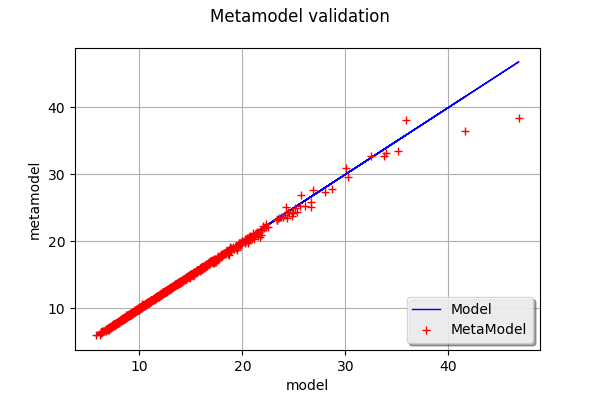

In [17]:
val.drawValidation()

## Sensitivity analysis

Retrieve Sobol' sensitivity measures associated to the polynomial chaos decomposition of the model.

In [18]:
chaosSI = ot.FunctionalChaosSobolIndices(result) 
print( chaosSI.summary() )

 input dimension: 4
 output dimension: 1
 basis size: 25
 mean: [12.5763]
 std-dev: [4.18011]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      2 | [0,1,0,0]                     | 0.776796
      1 | [1,0,0,0]                     | 0.134289
      4 | [0,0,0,1]                     | 0.0583109
      6 | [1,1,0,0]                     | 0.0100374
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.136147               | 0.147643              
        1 | 0.777299               | 0.795029              
        2 | 0.00882986             | 0.00981764            
        3 | 0.0585995              | 0.0667767             
-------------------------------

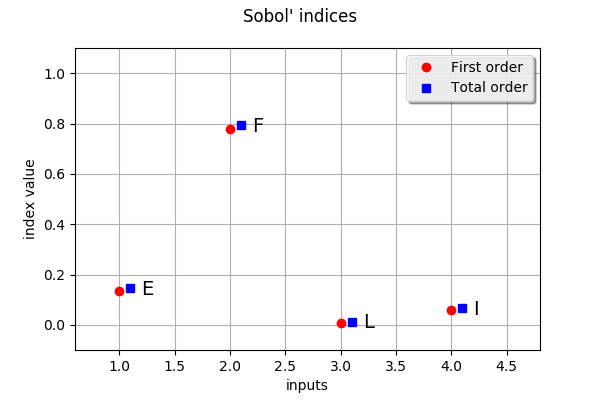

In [19]:
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)

## Exercice 1 : réduction de la taille du plan d'expériences d'apprentissage

* Utiliser un plan d'expériences de taille `N = 25`. 
* Exécuter à nouveau l'analyse. 
* Calculer le coefficient de prédictivité $Q^2$ (astuce : réduire le degré du polynôme)
* Afficher le graphique de validation du métamodèle. 
* Que peut-on conclure ?
* Exécuter à nouveau l'analyse pour voir l'influence de l'échantillon d'apprentissage sur les résultats. 
* Utiliser un plan d'expériences de taille `N = 100`. Exécuter à nouveau l'analyse : observer quel est l'impact sur les résultats numériques. 
* Pouvez-vous identifier 5 méthodes pour améliorer la qualité du métamodèle ?

## Exercice 2 : pourquoi éviter le calcul du R2

L'objectif de cet exercice est de clarifier le rôle d'un plan d'expériences d'apprentissage en comparaison d'un plan d'expériences de validation. A travers le calcul des coefficients $R^2$ et $Q^2$, nous analysons le problème du surapprentissage d'un métamodèle.

Soit $\left\{x^{(j)}_a\right\}_{j=1,...,n}$ un échantillon i.i.d. du vecteur aléatoire $X$ que nous allons utiliser pour la phase d'apprentissage du métamodèle. 

On note $g$ le modèle et $\tilde{g}$ le métamodèle. 

Soient 

$$
y^{(j)}_a = g\left(x^{(j)}_a\right), \qquad \tilde{y}^{(j)}_a = \tilde{g}\left(x^{(j)}_a\right)
$$

pour $j=1,...,n$ les sorties du modèle et du métamodèle sur la base d'apprentissage. 

Le coefficient $R^2$ est 

$$
R^2(g(x_a),\tilde{g}(x_a)) = 1 - \frac{ \sum_{j=1}^N \left( y^{(j)}_a - \tilde{y}^{(j)}_a \right)^2  }{ \sum_{j=1}^N \left( y^{(j)}_a - \bar{y}_a \right)^2 }
$$

où $\bar{y}_a = \frac{1} {N} \sum_{i=1}^N y^{(j)}_a$. 
Observons que le métamodèle n'est impliqué que dans le numérateur de la fraction. 

Supposons qu'un second plan d'expériences de validation du métamodèle est généré : $\left\{x^{(j)}_v\right\}_{j=1,...,n}$. L'objectif de ce second plan d'expériences est de tester le métamodèle sur des points d'entrées que le métamodèle n'a pas considéré pour estimer ses coefficients.

Soient $g(x_v)$ et $\tilde{g}(x_v)$ les sorties du modèle et du métamodèle sur le plan d'expériences de validation. 
Dans ce contexte, le coefficient $Q^2$ est égal au coefficient $R^2$ appliqué au plan d'expériences de validation :

$$
Q^2 = R^2(g(x_v),\tilde{g}(x_v)).
$$

Dans le contexte de tout métamodèle, et en particulier du chaos polynomial, il est plus prudent d'utiliser le coefficient $Q^2$ pour vérifier la qualité du métamodèle. En effet, lorsque le nombre de coefficients dans le chaos polynomial est suffisamment grand relativement à la taille du plan d'expériences, le coefficient $R^2$ peut laisser penser à un modèle de bonne qualité (i.e. proche de 1), mais le coefficient $Q^2$ peut révéler un modèle de mauvaise qualité (i.e. proche de 0). Cette situation est caractéristique d'un surapprentrissage.

*Questions* :

- Utiliser la méthode `getRelativeErrors` de l'objet `result` (de type `FunctionalChaosResult`). 
Cette fonction retourne la valeur de 
$$
\frac{ \sum_{j=1}^N \left( y^{(j)}_a - \tilde{y}^{(j)}_a \right)^2  }{ \sum_{j=1}^N \left( y^{(j)}_a - \bar{y}_a \right)^2 }
$$
- Calculer le coefficient $R^2$.
- Qu'observez-vous ?

## Exercice 3 : décroissance des coefficients

La fonction suivante produit un graphique présentant l'évolution de la valeur absolue des coefficients du chaos polynomial en fonction du degré de chaque terme polynomial dans la décomposition.

In [20]:
def plotCoefficientValueVSDegree(polynomialChaosResult):
    # Get coefficients
    coefficients = polynomialChaosResult.getCoefficients()
    abscoeff = [abs(coefficients[i][0]) for i in range(len(coefficients))]
    # Get total degree
    indices = result.getIndices()
    nbcoeffs = indices.getSize()
    total_p = []
    for k in range(nbcoeffs):
        multiindex = enumfunc(indices[k])
        totaldegree = sum(multiindex)
        total_p.append(totaldegree)
    #
    graph = ot.Graph("Polynomial chaos result","Total polynomial degree","Coefficient absolute value",True)
    cloud = ot.Cloud(total_p,abscoeff)
    graph.add(cloud)
    return graph

*Questions* :

* Utiliser la fonction `plotCoefficientValueVSDegree` sur le résultat du chaos polynomial : qu'observez-vous ?

## Exercice 4 : énumération hyperbolique et plan d'expériences de taille 25

* Use an hyperbolic enumeration with a training sample size equal to __N = 25__. 
* Compute the $Q^2$ coefficient. 
* Plot the metamodel validation graphics.
* Is the quality of the chaos acceptable ?

## Exercice 5 :  : nombre d'observations et nombre de paramètres

On souhaite vérifier que le nombre d'observations est suffisant pour estimer correctement les paramètres. 

* Calculer le nombre de paramètres estimés dans le chaos polynomial. Pour cela, utiliser la méthode `getCoefficients` de l'objet `result` pour obtenir les coefficients du chaos polynomial. 
* Calculer le nombre d'observations dans le plan d'expériences. 
* Calculer le ratio entre le nombre d'observations et le nombre de paramètres. 
* La taille du plan d'expériences est-elle suffisante pour estimer les paramètres ?

## Exercice 6 : analyse des résultats de la sélection de modèle

L'objectif de cet exercice est d'analyser les résultats de la sélection de modèle dans le but de réaliser un diagnostique de la qualité du métamodèle obtenu.

Considérons le ratio :
```
nbcoeffs / P
```
où `P` est le nombre maximal de coefficients associé à la règle d'énumération. Ce ratio entre 0 et 1 représente la proportions de termes retenus dans la méthode de sélection de modèle. 
* Si ce ratio est proche de zéro (par exemple inférieur à 0.01), alors c'est que le modèle est très creux car un faible nombre de coefficients suffit pour bien représenter la fonction. Dans ce cas, on aurait peut-être pu obtenir une qualité équivalente en utilisant un calcul moins coûteux en diminuant la valeur de `P`.
* Si ce ratio est proche de un (par exemple supérieur à 0.99), alors c'est que le modèle est très plein car presque tous les coefficients ont étés nécessaires pour bien représenter la fonction. Dans ce cas, on devrait peut-être améliorer la qualité en utilisant en augmentant la valeur de `P` (cela sera plus coûteux en termes de temps de calcul, sans nécessairement nécessiter de nouvelles évaluations de la fonction $g$).

L'objectif de cet exercice est d'explorer les différentes méthodes de l'objet `result`, une instance de la classe `FunctionalChaosResult`.

*Questions* :

* Utiliser la méthode `getIndices` pour créer la variable `indices` contenant la liste des indices des coefficients sélectionnés par la méthode. Afficher ces indices.
* Utiliser la méthode `getSize` de la variable `indices` pour obtenir le nombre de coefficients sélectionnés par la méthode.
* Utiliser la méthode `getCoefficients` pour obtenir la liste des valeurs des coefficients sélectionnés par la méthode. Afficher ces coefficients.
* Calculer le ratio `nbcoeffs / P`. Quelle est la valeur obtenue ? Que peut-on conclure relativement à la qualité du métamodèle ?
* La fonction `printCoefficientsTable` suivante utilise la règle d'énumération et le résultat d'un chaos polynomial pour afficher une table présentant les multi-indices, le degré du polynôme associé et la valeur du coefficient. 

In [21]:
def printCoefficientsTable(enumerateFunction, polynomialChaosResult):
    """
    Print the coefficients of the polynomial chaos.
    
    Parameters
    ----------
    enumerateFunction : ot.EnumerateFunction
    polynomialChaosResult : ot.PolynomialChaosResult
    """
    indices = polynomialChaosResult.getIndices()
    nbcoeffs = indices.getSize()
    print("# Indice, Multi-indice, Degree : Value")
    for k in range(nbcoeffs):
        multiindex = enumerateFunction(indices[k])
        degree = sum(multiindex)
        c = coefficients[k][0]
        print("#%d, %s (%s) : %s" % (k,multiindex,degree,c))
    return

Utiliser la fonction `printCoefficientsTable` avec les résultats du calcul. Qu'observez-vous ?